In [3]:
import xml.etree.ElementTree as et
import tkinter.filedialog
from tkinter import *
from tkinter import ttk
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import ward, single, complete, average, leaves_list
sns.set_theme()
from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter
from yellowbrick.cluster.silhouette import silhouette_visualizer
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import tanglegram as tg



from html2image import Html2Image
hti = Html2Image()

from scipy import cluster
from scipy import spatial
from sklearn import metrics 
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from pylatex import Document, table, MultiColumn, math
import sys, threading
sys.setrecursionlimit(10**7)
threading.stack_size(2**27) 


import matplotlib.pyplot as plt
from warnings import simplefilter

plt.style.use('ggplot')


simplefilter("ignore", cluster.hierarchy.ClusterWarning)


label_encoder = preprocessing.LabelEncoder()
scalar = preprocessing.MinMaxScaler()

In [30]:
def generate_string_list(data):
    return ''.join('l' for x in range(len(data.columns)))

In [31]:
def genenerate_longtabu(data):
    geometry_options = {
        "margin": "2.54cm",
        "includeheadfoot": True
    }
    doc = Document(page_numbers=True, geometry_options=geometry_options)
    table_type = 'c|'
    columns = generate_string_list(data)
    # Generate data table
    with doc.create(table.Tabular(table_type+""+columns, width=len(data.columns))) as data_table:
            data_table.add_caption("My Table Caption")
            data_table.add_hline()
            data_table.add_row(list(data.columns), strict=False)
            data_table.add_hline()
            data_table.end_table_header()
            data_table.add_hline()
            data_table.add_row((MultiColumn(len(data.columns), align='r',
                                data='Continued on Next Page'),))
            data_table.add_hline()
            data_table.end_table_footer()
            data_table.add_hline()
            data_table.add_row((MultiColumn(len(data.columns), align='r',
                                data='Not Continued on Next Page'),), strict=False)
            data_table.add_hline()
            data_table.end_table_last_footer()
            row = ["Content1", "9", "Longer String"]
            for row in list(data.index):
                data_table.add_row(data.loc[row], strict=False)

    doc.generate_pdf("longtable", clean_tex=False)

In [32]:
def get_xml_root():
    etree = et.parse(filedialog.askopenfilename())
    return etree.getroot()

In [33]:
class Clusters(dict):
    name = ''
    def __init__(self, s):
        self.name = s
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'
        
        html += '</table>'
        hti.screenshot(html_str=html, save_as=f'{self.name}.png', size=(500, 200))
        return html

In [34]:
def get_rules(xml_root):
    rule_attr_list = [xml.attrib for xml in xml_root.iter('rule')]
    rule_attr_dict = rule_attr_list.copy()
    rule_attr_data_frame = pd.DataFrame(list(rule_attr_dict))
    return rule_attr_data_frame

In [35]:
def get_attributes(xml_root):
    attribute_attr_list = [a.attrib for a in xml_root.find('attributes').iter('name')]
    attribute_attr_dict = attribute_attr_list.copy()
    attributes_attr_data_frame = pd.DataFrame(list(attribute_attr_dict))
    attributes_attr_data_frame.drop('valueID', axis='columns', inplace=True)
    attributes_attr_data_frame.dropna(subset=['attributeID'], inplace=True)
    return attributes_attr_data_frame

In [36]:
def init_rule_matrix(rule_data_frame, attribute_data_frame):
    for x in attribute_data_frame.values:
        rule_data_frame['attr_' + x] = np.nan
    return rule_data_frame


In [37]:
def get_rule_by_id(xml_root, id_rule):
    for rule in xml_root.iter('rule'):
        if rule.attrib['ruleID'] == id_rule:
            return rule

In [38]:
def populate_matrix_with_conditions(xml_root, data_frame):
    for i in range(len(list(data_frame.ruleID))):
        for k in list(get_rule_by_id(xml_root, data_frame.ruleID[i]).find('conditions')):
            data_frame.loc[
                data_frame['ruleID'] == data_frame.ruleID[i], str(
                    'attr_' + list(k)[0].attrib['attributeID'])] = list(k)[2].text
    return data_frame



In [39]:
def populate_matrix_with_conclusions(xml_root, data_frame):
    for i in range(len(list(data_frame.ruleID))):
        for k in list(get_rule_by_id(xml_root, data_frame.ruleID[i]).find('conclusion')):
            data_frame.loc[
                data_frame['ruleID'] == data_frame.ruleID[i], str(
                    'attr_' + list(k)[0].attrib['attributeID'])] = list(k)[2].text
    return data_frame


In [40]:
def normilize_types_of_column_values(data_frame, column):
    try:
        data_frame[column] = pd.to_numeric(data_frame[column], downcast="float")
    except:
        data_frame[column] = data_frame[column].astype(str)
    

In [41]:
def get_cluster_classes(den, name, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters(s=name)
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

In [7]:
def get_simbolic_values(xml_root):
    symbolic_value = []
    t = [a for a in xml_root.find('attributes').iter('symbolic_value')]
    for x in range(len(list(t))):
        symbolic_value.append(list(t)[x].find('name').text)
    return set(symbolic_value)

In [8]:
def comboSelected():
    label = Label(root, text=myCombo.get()).pack()

In [44]:
if __name__ == '__main__':
    root = get_xml_root()
    rule_attrs = get_rules(root)
    attribute_attrs = get_attributes(root)
    init_data = init_rule_matrix(rule_attrs, attribute_attrs)
    populate_matrix_with_conditions(root, init_data)
    

In [15]:
root = Tk()
root.title('Irakli Kardava - Magisterka')
root.geometry("400x400")

''

In [16]:
options = ['Euclidean', 'CityBlock', 'Mannhattan', 'Chebyshev']

In [17]:
myCombo = ttk.Combobox(root, value=options)
myCombo.current(0)
myCombo.bind("<<ComboboxSelected>>", comboSelected)
myCombo.pack()

In [16]:
data = populate_matrix_with_conclusions(root, init_data)

In [17]:
data.drop(data.columns[[0]], axis = 1, inplace = True)

In [18]:
# genenerate_longtabu(data.loc[:, data.columns != data.columns[[len(data.columns)-1]][0]])
# data.to_latex('data.tex')
# data.loc[:, data.columns != data.columns[[len(data.columns)-1]][0]].to_latex("data.tex")

In [19]:
data.columns[[len(data.columns)-1]][0]

'attr_733'

In [20]:
indexed_data = data

In [21]:
indexed_data = indexed_data.set_index('ruleID')

In [22]:
indexed_data

,attr_722,attr_723,attr_724,attr_725,attr_726,attr_727,attr_728,attr_729,attr_730,attr_731,attr_732,attr_733
ruleID,,,,,,,,,,,,
5650,a1,b1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5651,NaN,b1,c1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5652,NaN,NaN,c1,d1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5653,NaN,NaN,NaN,d1,e1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5654,NaN,NaN,NaN,NaN,e1,f1,NaN,NaN,NaN,NaN,NaN,NaN
5655,NaN,NaN,NaN,NaN,NaN,f1,g1,NaN,NaN,NaN,NaN,NaN
5656,NaN,NaN,NaN,NaN,NaN,NaN,g1,h1,NaN,NaN,NaN,NaN
5657,NaN,NaN,NaN,NaN,NaN,NaN,g1,h1,i1,NaN,NaN,NaN
5658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,i1,j1,NaN,NaN


In [23]:
for column in indexed_data.columns:
    normilize_types_of_column_values(indexed_data, column)

In [24]:
columns = list(indexed_data.columns)

In [25]:
numerical_columns = []
non_numerocal_columns = []
for col in columns:
    if col == 'ruleID':
        continue
    if np.issubdtype(indexed_data[col].dtype, np.number):
        numerical_columns.append(col)
    else:
        non_numerocal_columns.append(col)

In [26]:
numerical_data = indexed_data[numerical_columns]

In [27]:
numerical_data = numerical_data.fillna(float(0))

In [28]:
if len(numerical_columns)> 0:
    scalar.fit(numerical_data)
    scalar_data = scalar.transform(numerical_data)
    indexed_data[numerical_columns] = scalar_data

In [29]:
symbolic_value = list(get_simbolic_values(root))

In [30]:
for s in symbolic_value:
    for categorical in non_numerocal_columns:
        indexed_data.loc[indexed_data[categorical] == s, categorical] = symbolic_value.index(s)

In [31]:
 for categorical in non_numerocal_columns:
        indexed_data.loc[indexed_data[categorical] == 'nan', categorical] = 8

In [32]:
indexed_data[numerical_columns] = numerical_data

In [33]:
indexed_data.to_latex('index.tex')

In [34]:
euclidean_dist = spatial.distance.cdist(indexed_data.to_numpy(), indexed_data.to_numpy(), 'euclidean')
chebyshev_dist = spatial.distance.cdist(indexed_data.to_numpy(), indexed_data.to_numpy(), 'chebyshev')
mannhattan_dist = spatial.distance.cdist(indexed_data.to_numpy(), indexed_data.to_numpy(), 'cityblock')
canberra_dist = spatial.distance.cdist(indexed_data.to_numpy(), indexed_data.to_numpy(), 'canberra')

In [35]:
euclidean_distance_mat = pd.DataFrame(euclidean_dist, index=indexed_data.index, columns=indexed_data.index)

In [36]:
chebyshev_distance_mat = pd.DataFrame(chebyshev_dist, index=indexed_data.index, columns=indexed_data.index)

In [37]:
manhattan_distance_mat = pd.DataFrame(mannhattan_dist, index=indexed_data.index, columns=indexed_data.index)

In [38]:
canberra_distance_mat = pd.DataFrame(canberra_dist, index=indexed_data.index, columns=indexed_data.index)

In [39]:
#### Euclidean distance dendrogram

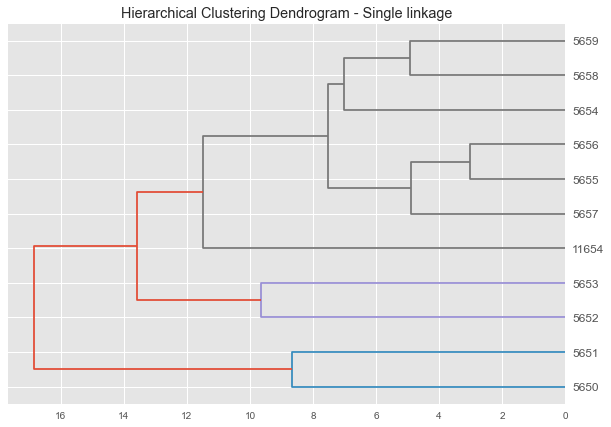

In [40]:
mat_single = single(euclidean_dist)
plt.figure(figsize=(10,7))
plt.title(f'Hierarchical Clustering Dendrogram - Single linkage')
dn_single = cluster.hierarchy.dendrogram(mat_single, labels=euclidean_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
fl_single = cluster.hierarchy.fcluster(mat_single,len(set(dn_single['color_list'])), criterion='maxclust', R=None, monocrit=None)
eu_cluster_group_dataframe = pd.DataFrame({"cluster":fl_single, "labels":list(euclidean_distance_mat.columns)})
eu_cluster_group_dataframe = eu_cluster_group_dataframe.set_index("labels")

In [41]:
eu_cluster_group_dataframe.to_latex('./euclidean/single/euclidean-single-test_1B.tex')

In [42]:
get_cluster_classes(dn_single, name='euclidean-single-test_1B')

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"


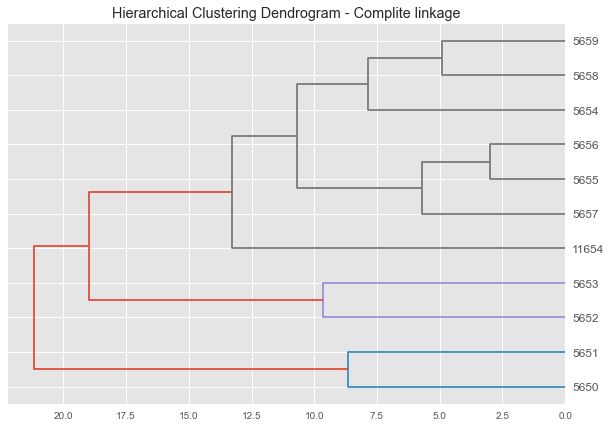

In [43]:
mat_complite = complete(euclidean_dist)
plt.figure(figsize=(10,7))
plt.title(f'Hierarchical Clustering Dendrogram - Complite linkage')
dn_complete = cluster.hierarchy.dendrogram(mat_complite, labels=euclidean_distance_mat.index, orientation="left",distance_sort='ascending')
fl_complite = cluster.hierarchy.fcluster(mat_complite,len(set(dn_complete['color_list'])), criterion='maxclust', R=None, monocrit=None)
eu_complite_cluster_group_dataframe = pd.DataFrame({"cluster":fl_complite, "labels":list(euclidean_distance_mat.columns)})
eu_complite_cluster_group_dataframe = eu_complite_cluster_group_dataframe.set_index("labels")

In [44]:
eu_complite_cluster_group_dataframe.to_latex('./euclidean/complete/euclidean-complete-test_1B.tex')

In [45]:
get_cluster_classes(dn_complete, name='euclidean-complete-test_1B')

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"


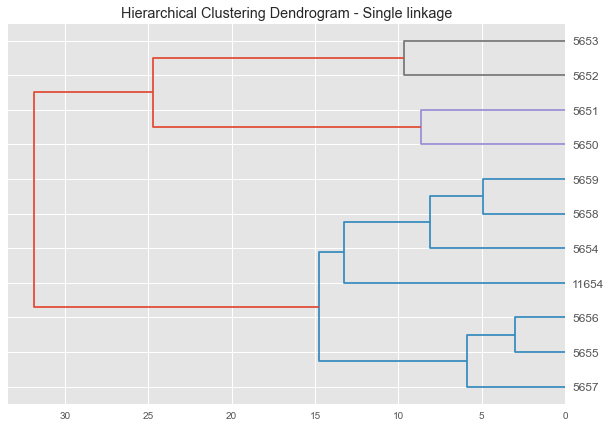

In [46]:
mat_ward = ward(euclidean_dist)
plt.figure(figsize=(10,7))
plt.title(f'Hierarchical Clustering Dendrogram - Single linkage')
dn_ward = cluster.hierarchy.dendrogram(mat_ward, labels=euclidean_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
fl_ward = cluster.hierarchy.fcluster(mat_ward,len(set(dn_ward['color_list'])), criterion='maxclust', R=None, monocrit=None)
eu_ward_cluster_group_dataframe = pd.DataFrame({"cluster":fl_ward, "labels":list(euclidean_distance_mat.columns)})
eu_ward_cluster_group_dataframe = eu_ward_cluster_group_dataframe.set_index("labels")

In [47]:
eu_ward_cluster_group_dataframe.to_latex('./euclidean/ward/euclidean-ward-test_1B.tex')

In [48]:
get_cluster_classes(dn_ward, name='euclidean-ward-test_1B')

C1,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"
C2,"['5650', '5651']"
C3,"['5652', '5653']"


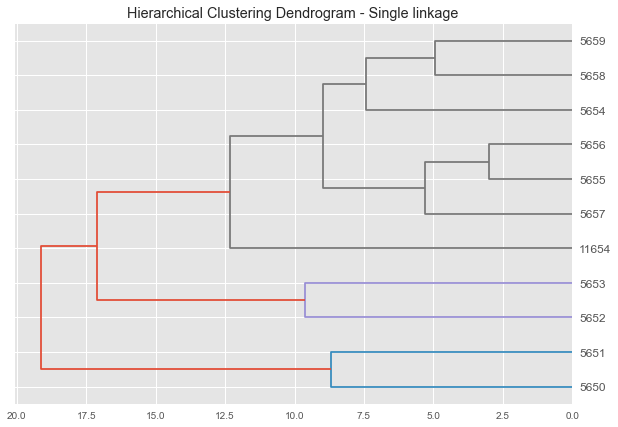

In [49]:
mat_average = average(euclidean_dist)
plt.figure(figsize=(10,7))
plt.title(f'Hierarchical Clustering Dendrogram - Single linkage')
dn_average = cluster.hierarchy.dendrogram(mat_average, labels=euclidean_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
fl_average = cluster.hierarchy.fcluster(mat_average,len(set(dn_average['color_list'])), criterion='maxclust', R=None, monocrit=None)
eu_average_cluster_group_dataframe = pd.DataFrame({"cluster":fl_average, "labels":list(euclidean_distance_mat.columns)})
eu_average_cluster_group_dataframe = eu_average_cluster_group_dataframe.set_index("labels")

In [50]:
eu_average_cluster_group_dataframe.to_latex('./euclidean/average/euclidean-average-test_1B.tex')

In [51]:
get_cluster_classes(dn_average, name='euclidean-average-test_1B')

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"


0.3846567333418779


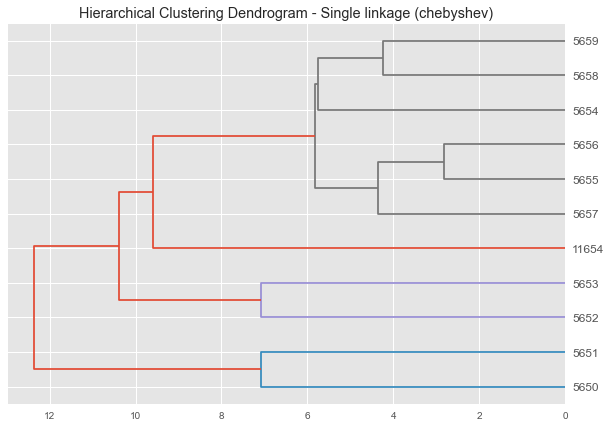

In [52]:
cheb_mat_single = single(chebyshev_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Single linkage (chebyshev)' )
cheb_dn_single = cluster.hierarchy.dendrogram(cheb_mat_single, labels=chebyshev_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
cheb_fl_single = cluster.hierarchy.fcluster(cheb_mat_single,len(set(cheb_dn_single['color_list'])), criterion='maxclust', R=None, monocrit=None)
cheb_signle_cluster_group_dataframe = pd.DataFrame({"cluster":cheb_fl_single, "labels":list(euclidean_distance_mat.columns)})
cheb_signle_cluster_group_dataframe = cheb_signle_cluster_group_dataframe.set_index("labels")
silhuette_avg = metrics.silhouette_score(chebyshev_dist, cheb_fl_single)
print(silhuette_avg)

In [53]:
cheb_signle_cluster_group_dataframe.to_latex('./chebyszev/single/chebyszev-single-test_1B.tex')

In [54]:
get_cluster_classes(cheb_dn_single, name='chebyszev-single-test_1B') 

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5655', '5656', '5657', '5658', '5659', '5654']"
C0,['11654']


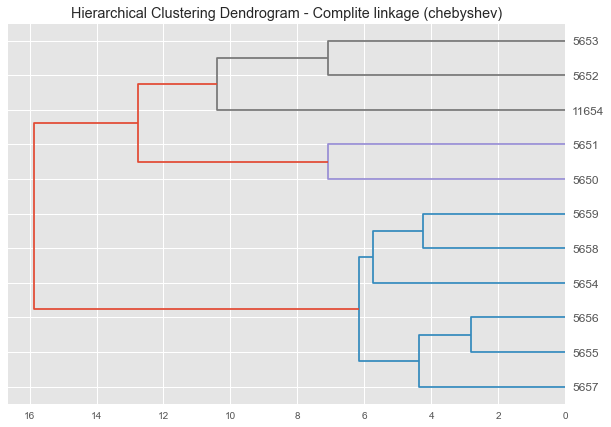

In [55]:
cheb_mat_complete = complete(chebyshev_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Complite linkage (chebyshev)')
cheb_dn_complete = cluster.hierarchy.dendrogram(cheb_mat_complete, labels=chebyshev_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
cheb_fl_complete = cluster.hierarchy.fcluster(cheb_mat_complete,len(set(cheb_dn_complete['color_list'])), criterion='maxclust', R=None, monocrit=None)
cheb_complete_cluster_group_dataframe = pd.DataFrame({"cluster":cheb_fl_complete, "labels":list(euclidean_distance_mat.columns)})
cheb_complete_cluster_group_dataframe = cheb_complete_cluster_group_dataframe.set_index("labels")

In [56]:
cheb_complete_cluster_group_dataframe.to_latex('./chebyszev/complete/chebyszev-complete-test_1B.tex')

In [57]:
get_cluster_classes(cheb_dn_complete, name='chebyszev-complete-test_1B')   

C1,"['5655', '5656', '5657', '5658', '5659', '5654']"
C2,"['5650', '5651']"
C3,"['5652', '5653', '11654']"


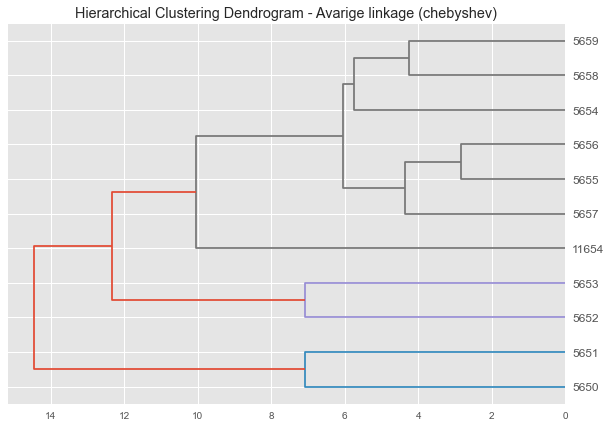

In [58]:
cheb_mat_average = average(chebyshev_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Avarige linkage (chebyshev)')
cheb_dn_average = cluster.hierarchy.dendrogram(cheb_mat_average, labels=chebyshev_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
cheb_fl_average = cluster.hierarchy.fcluster(cheb_mat_average,len(set(cheb_dn_average['color_list'])), criterion='maxclust', R=None, monocrit=None)
cheb_average_cluster_group_dataframe = pd.DataFrame({"cluster":cheb_fl_average, "labels":list(euclidean_distance_mat.columns)})
cheb_average_cluster_group_dataframe = cheb_average_cluster_group_dataframe.set_index("labels")

In [59]:
cheb_average_cluster_group_dataframe.to_latex('./chebyszev/average/chebyszev-average-test_1B.tex')

In [60]:
get_cluster_classes(cheb_dn_average, name='chebyszev-average-test_1B')   

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"


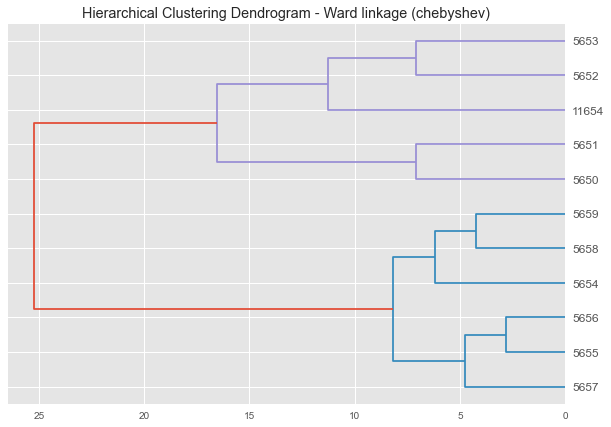

In [61]:
cheb_mat_ward = ward(chebyshev_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Ward linkage (chebyshev)')
cheb_dn_ward = cluster.hierarchy.dendrogram(cheb_mat_ward, labels=chebyshev_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
cheb_fl_ward = cluster.hierarchy.fcluster(cheb_mat_ward,len(set(cheb_dn_ward['color_list'])), criterion='maxclust', R=None, monocrit=None)
cheb_ward_cluster_group_dataframe = pd.DataFrame({"cluster":cheb_fl_ward, "labels":list(euclidean_distance_mat.columns)})
cheb_ward_cluster_group_dataframe = cheb_ward_cluster_group_dataframe.set_index("labels")

In [62]:
cheb_ward_cluster_group_dataframe.to_latex('./chebyszev/ward/chebyszev-ward-test_1B.tex')

In [63]:
get_cluster_classes(cheb_dn_ward, name='chebyszev-ward-test_1B')

C1,"['5655', '5656', '5657', '5658', '5659', '5654']"
C2,"['5650', '5651', '5652', '5653', '11654']"


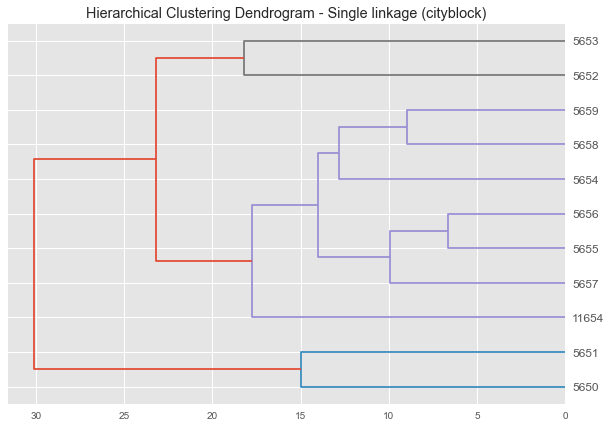

In [64]:
man_mat_single = single(mannhattan_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Single linkage (cityblock)')
man_dn_single = cluster.hierarchy.dendrogram(man_mat_single, labels=manhattan_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
man_fl_single = cluster.hierarchy.fcluster(man_mat_single,len(set(man_dn_single['color_list'])), criterion='maxclust', R=None, monocrit=None)
man_single_cluster_group_dataframe = pd.DataFrame({"cluster":man_fl_single, "labels":list(manhattan_distance_mat.columns)})
man_single_cluster_group_dataframe = man_single_cluster_group_dataframe.set_index("labels")

In [65]:
man_single_cluster_group_dataframe.to_latex('./cityblock/single/cityblock-single-test_1B.tex')

In [66]:
get_cluster_classes(man_dn_single, name='cityblock-single-test_1B')

C1,"['5650', '5651']"
C2,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"
C3,"['5652', '5653']"


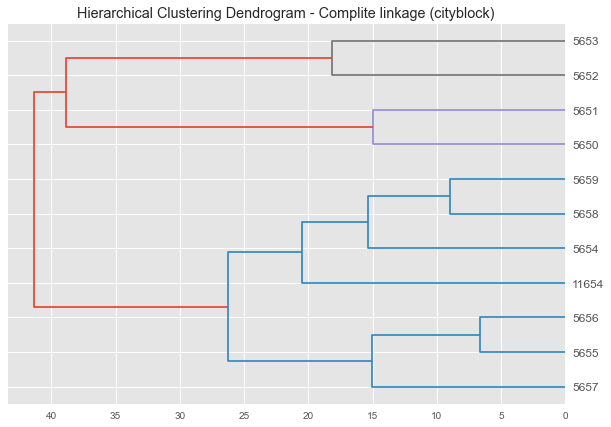

In [67]:
man_mat_complete = complete(mannhattan_dist)
plt.figure(figsize=(10,7))
plt.title(f'Hierarchical Clustering Dendrogram - Complite linkage (cityblock)')
man_dn_complite = cluster.hierarchy.dendrogram(man_mat_complete, labels=manhattan_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
man_fl_complete = cluster.hierarchy.fcluster(man_mat_complete,len(set(man_dn_complite['color_list'])), criterion='maxclust', R=None, monocrit=None)
man_complete_cluster_group_dataframe = pd.DataFrame({"cluster":man_fl_complete, "labels":list(manhattan_distance_mat.columns)})
man_complete_cluster_group_dataframe = man_complete_cluster_group_dataframe.set_index("labels")

In [68]:
man_complete_cluster_group_dataframe.to_latex('./cityblock/complete/cityblock-complete-test_1B.tex')

In [69]:
get_cluster_classes(man_dn_complite, name='cityblock-complete-test_1B')

C1,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"
C2,"['5650', '5651']"
C3,"['5652', '5653']"


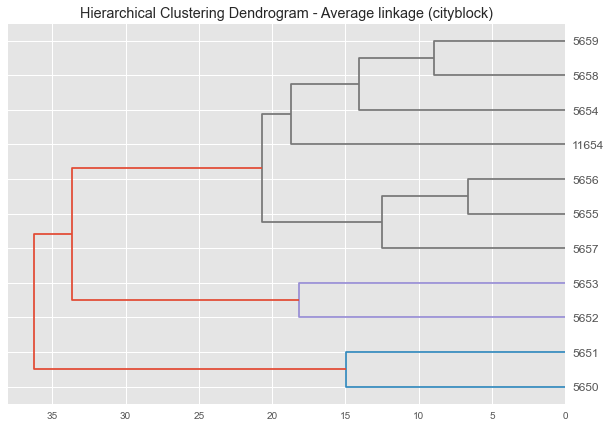

In [70]:
man_mat_average = average(mannhattan_dist)
plt.figure(figsize=(10,7))
plt.title(f'Hierarchical Clustering Dendrogram - Average linkage (cityblock)')
man_dn_average = cluster.hierarchy.dendrogram(man_mat_average, labels=manhattan_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
man_fl_average = cluster.hierarchy.fcluster(man_mat_average,len(set(man_dn_average['color_list'])), criterion='maxclust', R=None, monocrit=None)
man_average_cluster_group_dataframe = pd.DataFrame({"cluster":man_fl_average, "labels":list(manhattan_distance_mat.columns)})
man_average_cluster_group_dataframe = man_average_cluster_group_dataframe.set_index("labels")

In [71]:
man_average_cluster_group_dataframe.to_latex('./cityblock/average/cityblock-average-test_1B.tex')

In [72]:
get_cluster_classes(man_dn_average, name='cityblock-average-test_1B')

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"


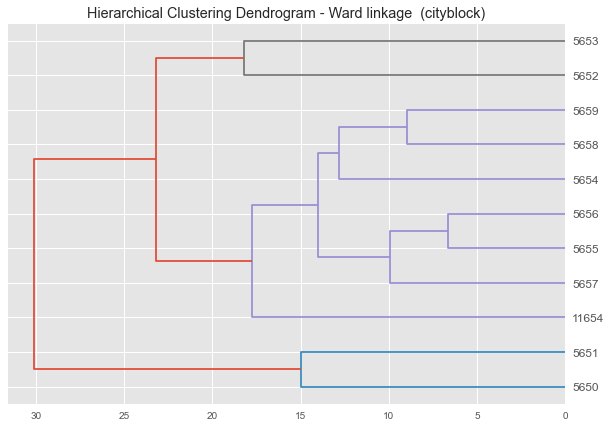

In [73]:
man_mat_ward = single(mannhattan_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Ward linkage  (cityblock)')
man_dn_ward = cluster.hierarchy.dendrogram(man_mat_ward, labels=manhattan_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
man_fl_ward = cluster.hierarchy.fcluster(man_mat_ward,len(set(man_dn_ward['color_list'])), criterion='maxclust', R=None, monocrit=None)
man_ward_cluster_group_dataframe = pd.DataFrame({"cluster":man_fl_ward, "labels":list(manhattan_distance_mat.columns)})
man_ward_cluster_group_dataframe = man_ward_cluster_group_dataframe.set_index("labels")

In [74]:
man_ward_cluster_group_dataframe.to_latex('./cityblock/ward/cityblock-ward-test_1B.tex')

In [75]:
get_cluster_classes(man_dn_ward, name='cityblock-ward-test_1B')

C1,"['5650', '5651']"
C2,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"
C3,"['5652', '5653']"


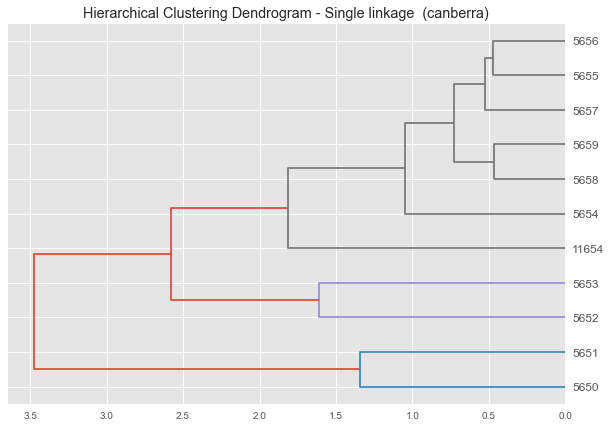

In [76]:
can_mat_single = single(canberra_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Single linkage  (canberra)')
can_dn_single = cluster.hierarchy.dendrogram(can_mat_single, labels=canberra_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
can_fl_single = cluster.hierarchy.fcluster(can_mat_single,len(set(can_dn_single['color_list'])), criterion='maxclust', R=None, monocrit=None)
can_single_cluster_group_dataframe = pd.DataFrame({"cluster":can_fl_single, "labels":list(canberra_distance_mat.columns)})
can_single_cluster_group_dataframe = can_single_cluster_group_dataframe.set_index("labels")

In [77]:
can_single_cluster_group_dataframe.to_latex('./canberra/single/canberra-single-test_1B.tex')

In [78]:
get_cluster_classes(can_dn_single, name='canberra-single-test_1B')

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5658', '5659', '5655', '5656', '5657', '5654', '11654']"


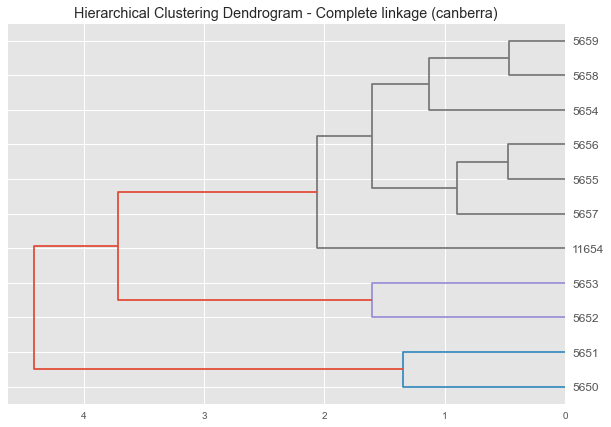

In [79]:
can_mat_complete = complete(canberra_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Complete linkage (canberra)')
can_dn_complete = cluster.hierarchy.dendrogram(can_mat_complete, labels=canberra_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
can_fl_complete = cluster.hierarchy.fcluster(can_mat_complete,len(set(can_dn_complete['color_list'])), criterion='maxclust', R=None, monocrit=None)
can_complete_cluster_group_dataframe = pd.DataFrame({"cluster":can_fl_complete, "labels":list(canberra_distance_mat.columns)})
can_complete_cluster_group_dataframe = can_complete_cluster_group_dataframe.set_index("labels")

In [80]:
can_complete_cluster_group_dataframe.to_latex('./canberra/complete/canberra-complete-test_1B.tex')

In [81]:
get_cluster_classes(can_dn_complete, name='canberra-complete-test_1B')

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"


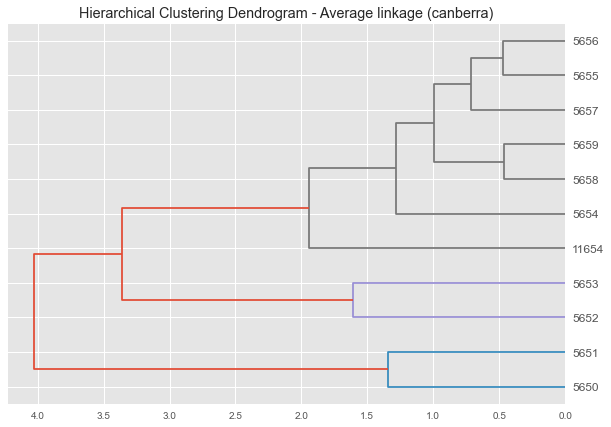

In [82]:
can_mat_average = average(canberra_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Average linkage (canberra)')
can_dn_average = cluster.hierarchy.dendrogram(can_mat_average, labels=canberra_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
can_fl_average = cluster.hierarchy.fcluster(can_mat_average,len(set(can_dn_average['color_list'])), criterion='maxclust', R=None, monocrit=None)
can_average_cluster_group_dataframe = pd.DataFrame({"cluster":can_fl_average, "labels":list(canberra_distance_mat.columns)})
can_average_cluster_group_dataframe = can_average_cluster_group_dataframe.set_index("labels")

In [83]:
can_average_cluster_group_dataframe.to_latex('./canberra/average/canberra-average-test_1B.tex')

In [84]:
get_cluster_classes(can_dn_complete, name='canberra-average-test_1B')

C1,"['5650', '5651']"
C2,"['5652', '5653']"
C3,"['5655', '5656', '5657', '5658', '5659', '5654', '11654']"


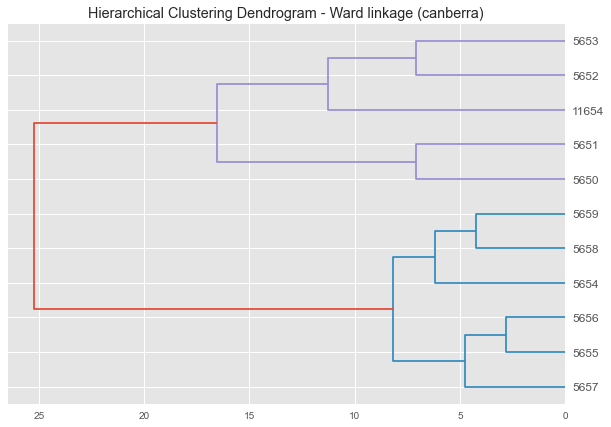

In [85]:
can_mat_ward = ward(chebyshev_dist)
plt.figure(figsize=(10,7))
plt.title('Hierarchical Clustering Dendrogram - Ward linkage (canberra)')
cheb_dn_ward = cluster.hierarchy.dendrogram(can_mat_ward, labels=canberra_distance_mat.index, leaf_rotation=0,orientation="left",distance_sort='ascending')
can_fl_ward = cluster.hierarchy.fcluster(can_mat_ward,len(set(cheb_dn_ward['color_list'])), criterion='maxclust', R=None, monocrit=None)
can_ward_cluster_group_dataframe = pd.DataFrame({"cluster":can_fl_ward, "labels":list(canberra_distance_mat.columns)})
can_ward_cluster_group_dataframe = can_ward_cluster_group_dataframe.set_index("labels")

In [86]:
can_ward_cluster_group_dataframe.to_latex('./canberra/ward/canberra-ward-test_1B.tex')

In [87]:
get_cluster_classes(cheb_dn_ward, name='canberra-ward-test_1B')

C1,"['5655', '5656', '5657', '5658', '5659', '5654']"
C2,"['5650', '5651', '5652', '5653', '11654']"


In [88]:
euclidean_single = metrics.silhouette_score(euclidean_dist, fl_single)
euclidean_complite = metrics.silhouette_score(euclidean_dist, fl_complite)
euclidean_ward = metrics.silhouette_score(euclidean_dist, fl_ward)
euclidean_average = metrics.silhouette_score(euclidean_dist, fl_average)

In [89]:
silhouette_euclidean_table = pd.DataFrame({"linkage":['single', 'complete','ward', 'average'], "score":[euclidean_single, euclidean_complite,euclidean_ward, euclidean_average  ]})

<AxesSubplot:xlabel='linkage'>

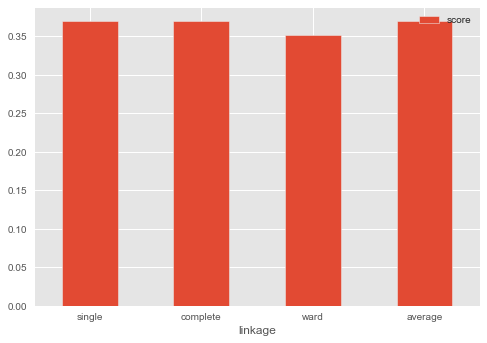

In [90]:
silhouette_euclidean_table.plot.bar(x='linkage', rot=0)

In [91]:
chebyshev_single = metrics.silhouette_score(chebyshev_dist, cheb_fl_single)
chebyshev_complite = metrics.silhouette_score(chebyshev_dist, cheb_fl_complete)
chebyshev_ward = metrics.silhouette_score(chebyshev_dist, cheb_fl_ward)
chebyshev_average = metrics.silhouette_score(chebyshev_dist, cheb_fl_average)

In [92]:
silhouette_chebyshev_table = pd.DataFrame({"linkage":['single', 'complete','ward', 'average'], "score":[chebyshev_single, chebyshev_complite,chebyshev_ward, chebyshev_average  ]})

<AxesSubplot:xlabel='linkage'>

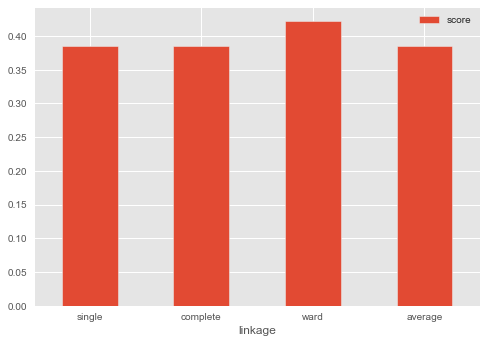

In [93]:
silhouette_chebyshev_table.plot.bar(x='linkage', rot=0)

In [94]:
man_single = metrics.silhouette_score(mannhattan_dist, man_fl_single)
man_complite = metrics.silhouette_score(mannhattan_dist, man_fl_complete)
man_ward = metrics.silhouette_score(mannhattan_dist, man_fl_ward)
man_average = metrics.silhouette_score(mannhattan_dist, man_fl_average)

In [95]:
silhouette_cityblock_table = pd.DataFrame({"linkage":['single', 'complete','ward', 'average'], "score":[man_single, man_complite,man_ward, man_average  ]})

<AxesSubplot:xlabel='linkage'>

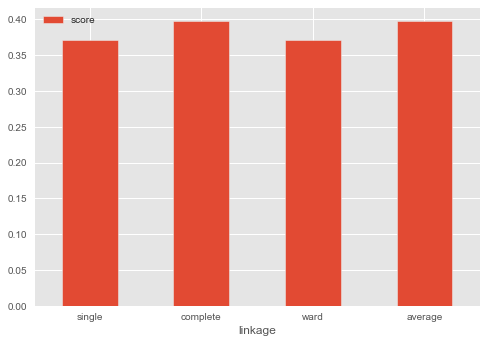

In [96]:
silhouette_cityblock_table.plot.bar(x='linkage', rot=0)

In [97]:
can_single = metrics.silhouette_score(canberra_dist, can_fl_single)
can_complite = metrics.silhouette_score(canberra_dist, can_fl_complete)
can_ward = metrics.silhouette_score(canberra_dist, can_fl_ward)
can_average = metrics.silhouette_score(canberra_dist, can_fl_average)

In [98]:
silhouette_canberra_table = pd.DataFrame({"linkage":['single', 'complete','ward', 'average'], "score":[can_single, can_complite,can_ward, can_average  ]})

<AxesSubplot:xlabel='linkage'>

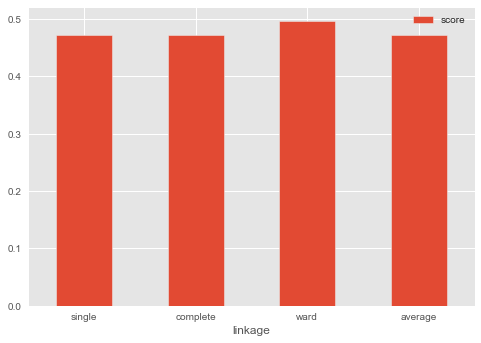

In [99]:
silhouette_canberra_table.plot.bar(x='linkage', rot=0)

In [100]:
a = AgglomerativeClustering(affinity='euclidean', linkage='ward')
a.fit_predict(indexed_data)

print(a.n_clusters)

b = AgglomerativeClustering(affinity='euclidean', linkage='single')
b.fit_predict(indexed_data)

print(b.n_clusters)

c = AgglomerativeClustering(affinity='euclidean', linkage='complete')
c.fit_predict(indexed_data)

print(c.n_clusters)




2
2
2


[[5 0 8 8 8 8 8 8 8 8 8 8]
 [8 0 3 8 8 8 8 8 8 8 8 8]
 [8 8 3 1 8 8 8 8 8 8 8 8]
 [8 8 8 1 4 8 8 8 8 8 8 8]
 [8 8 8 8 4 8 8 8 8 8 8 8]
 [8 8 8 8 8 8 12 8 8 8 8 8]
 [8 8 8 8 8 8 12 6 8 8 8 8]
 [8 8 8 8 8 8 12 6 11 8 8 8]
 [8 8 8 8 8 8 8 8 11 9 8 8]
 [8 8 8 8 8 8 8 8 8 9 7 8]
 [8 8 8 8 8 8 8 8 8 9 8 2]]
[5 8 8 8 8 8 8 8 8 8 8]
[0 0 8 8 8 8 8 8 8 8 8]



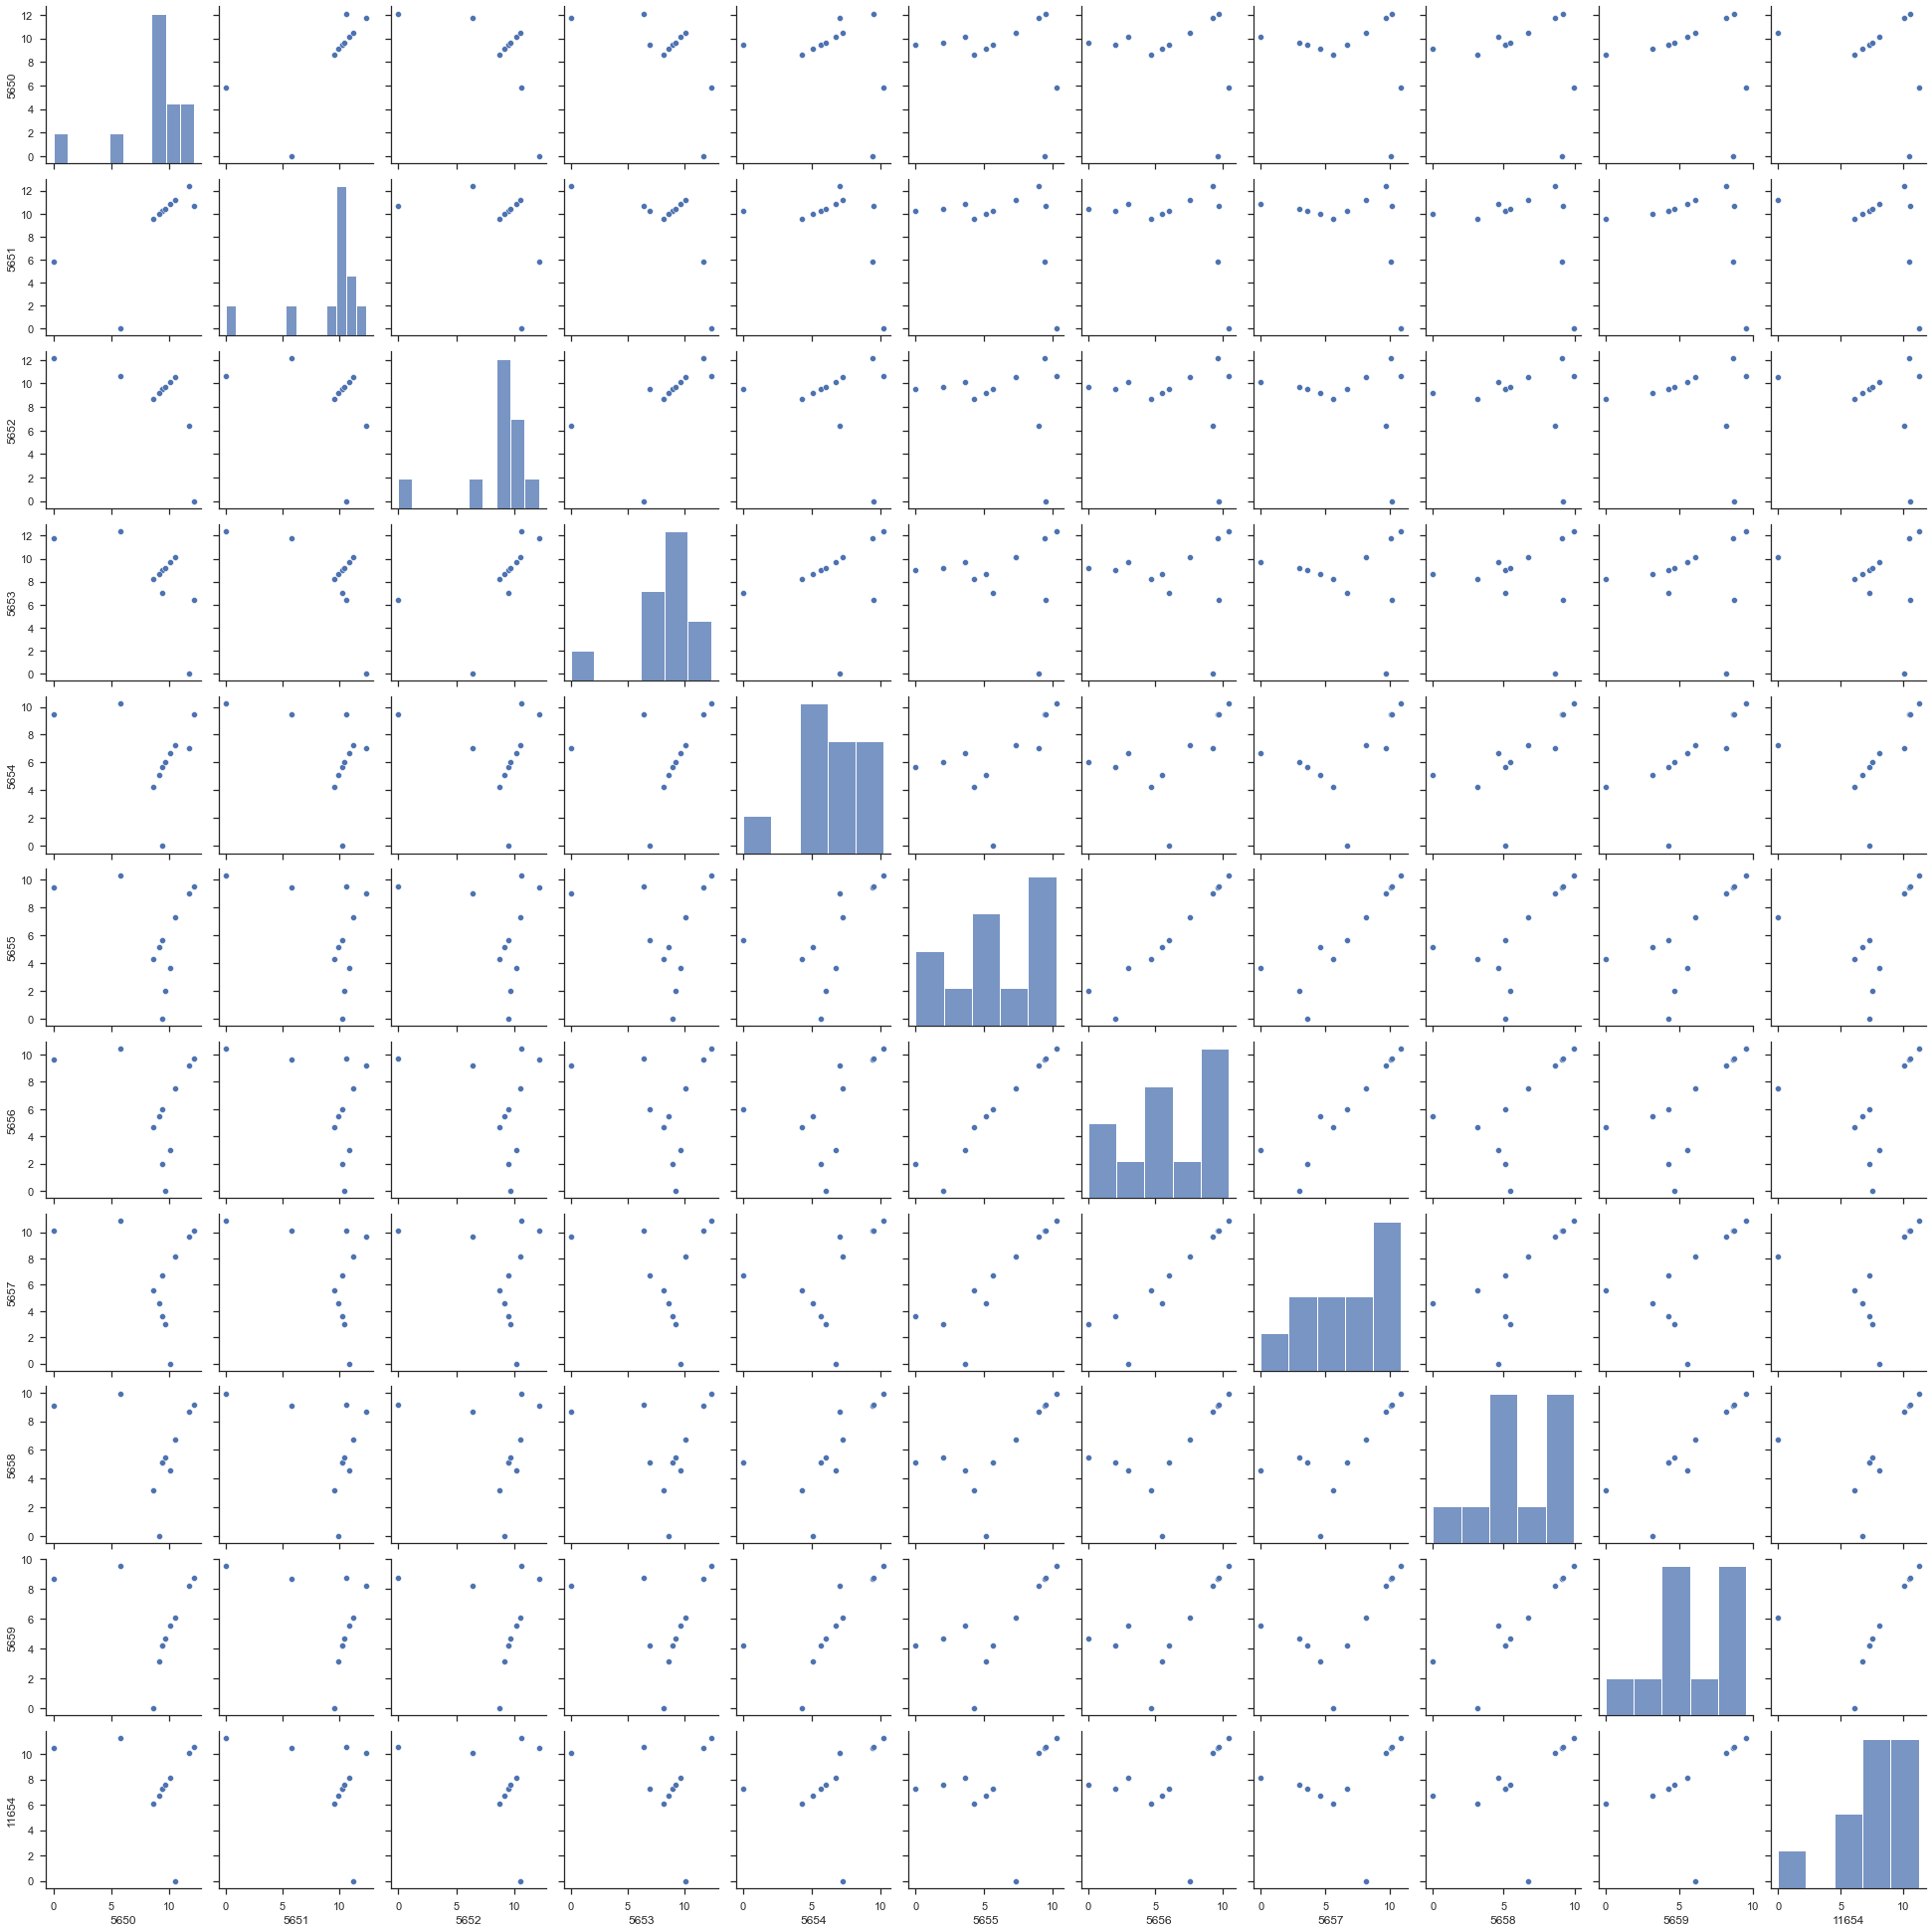

In [101]:
x = indexed_data.to_numpy()
y = indexed_data.to_numpy()
print(x)
print(x[:,0])
print(x[:,1])
sns.set_theme(style="ticks")
sns.color_palette("hls", 8)
df = sns.load_dataset("penguins")
sns.pairplot(euclidean_distance_mat,palette="muted")

print()


In [684]:
indexed_data

,attr_722,attr_723,attr_724,attr_725,attr_726,attr_727,attr_728,attr_729,attr_730,attr_731,attr_732,attr_733
ruleID,,,,,,,,,,,,
5650,1,10,8,8,8,8,8,8,8,8,8,8
5651,8,10,8,8,8,8,8,8,8,8,8,8
5652,8,8,8,2,8,8,8,8,8,8,8,8
5653,8,8,8,2,3,8,8,8,8,8,8,8
5654,8,8,8,8,3,9,8,8,8,8,8,8
5655,8,8,8,8,8,9,4,8,8,8,8,8
5656,8,8,8,8,8,8,4,5,8,8,8,8
5657,8,8,8,8,8,8,4,5,7,8,8,8
5658,8,8,8,8,8,8,8,8,7,0,8,8


In [685]:
euclidean_distance_mat.index.name

'ruleID'

In [102]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [103]:
def loop_plot(plots):
    figs={}
    axs={}
    for idx,plot in enumerate(plots):
        figs[idx]=plt.figure()
        axs[idx]=figs[idx].add_subplot(111)
        axs[idx].plot(plot[0],plot[1])
    return figs, axs 

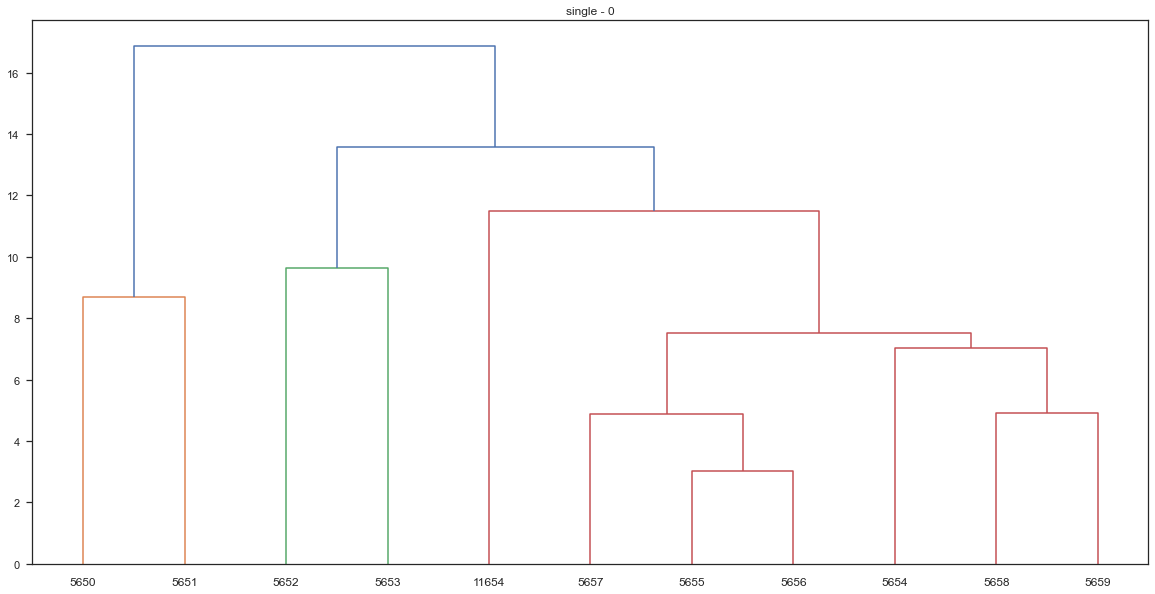

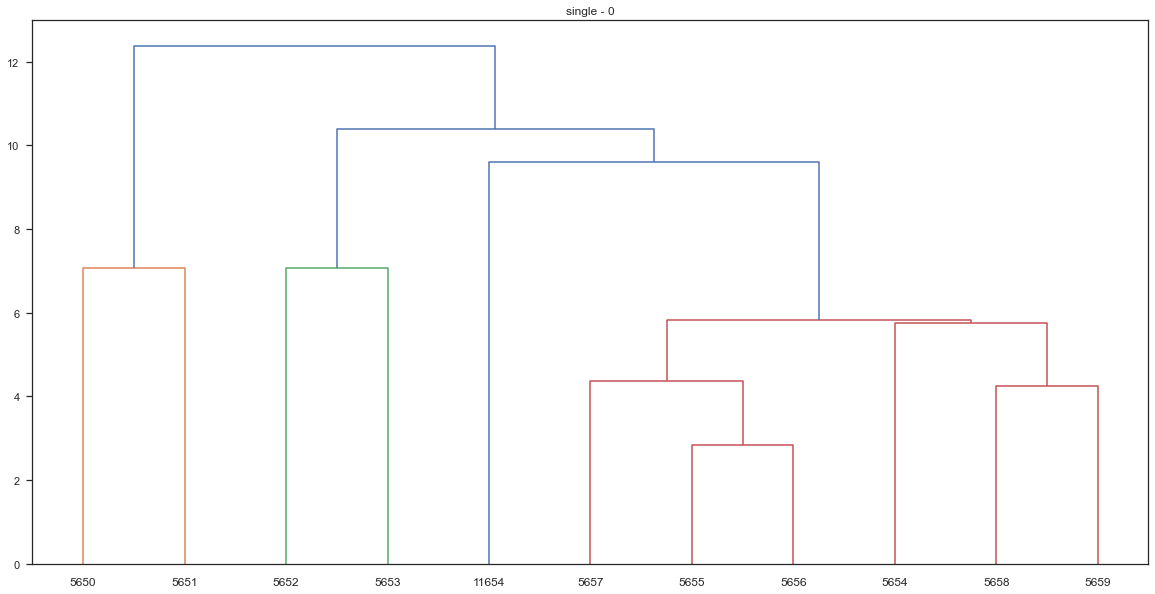

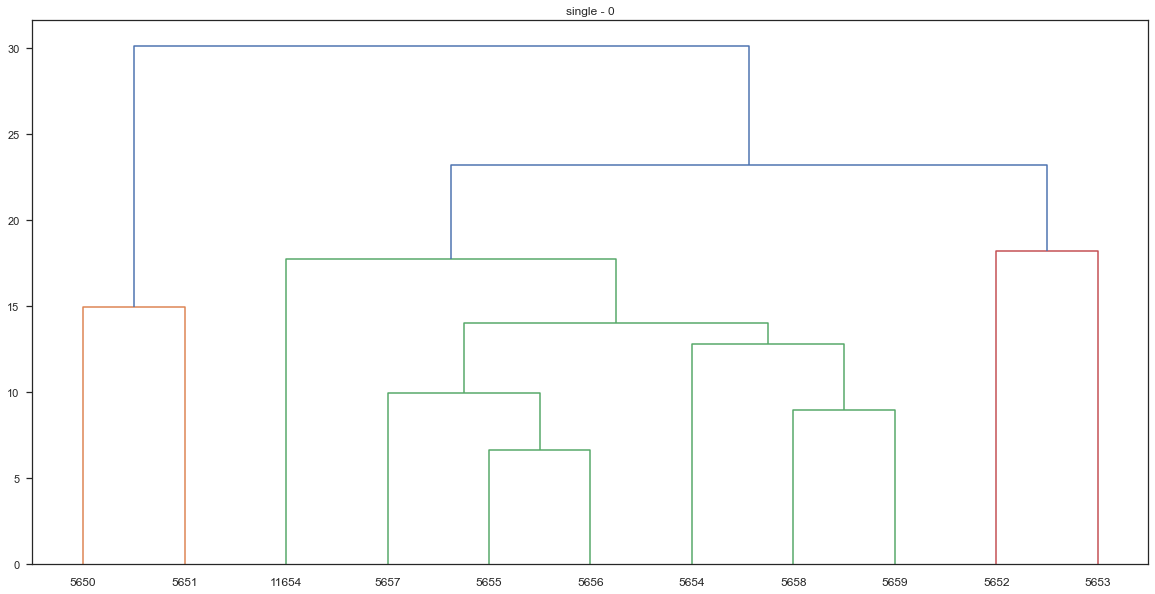

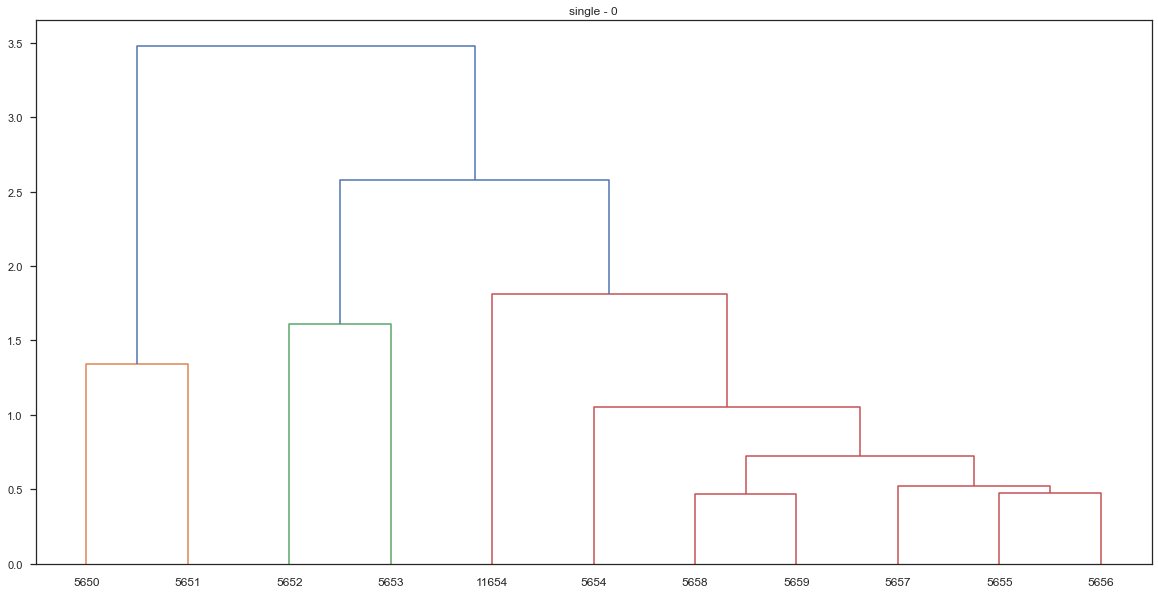

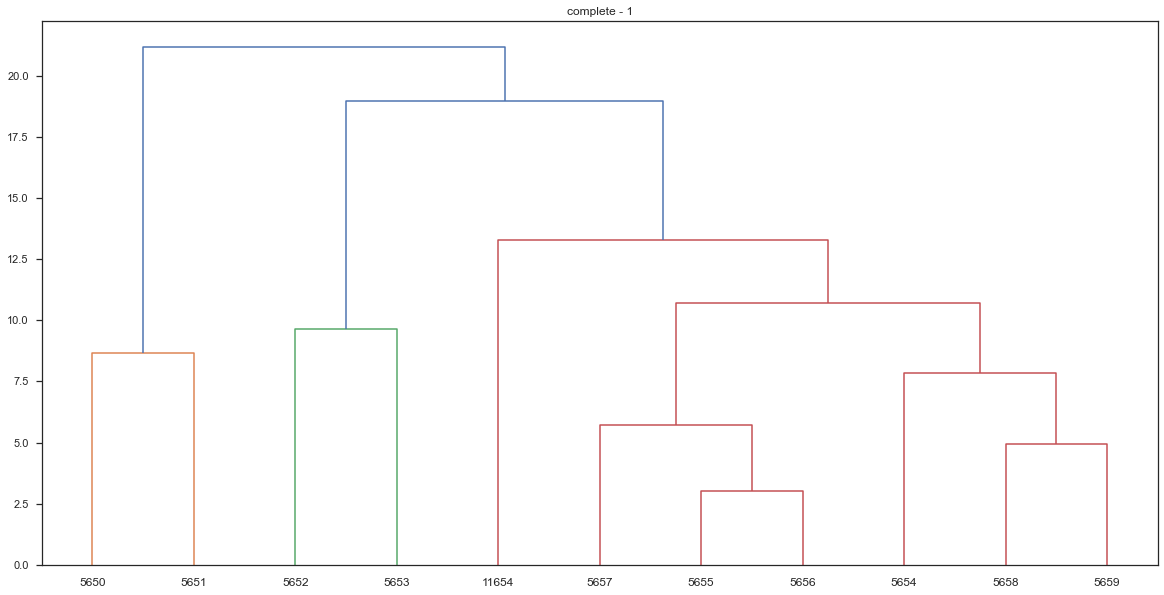

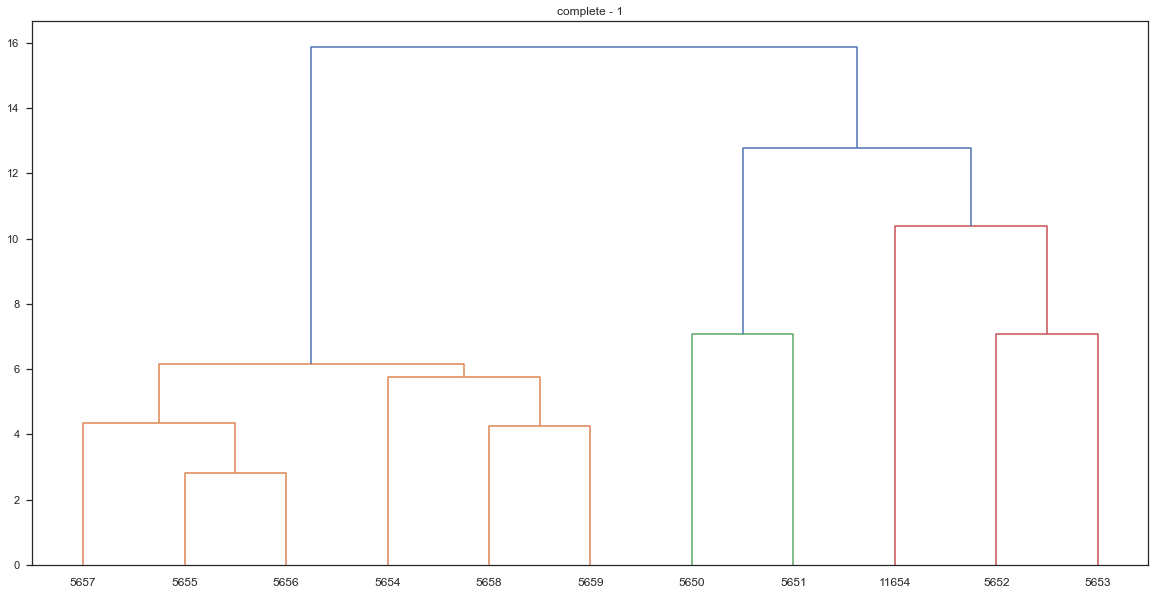

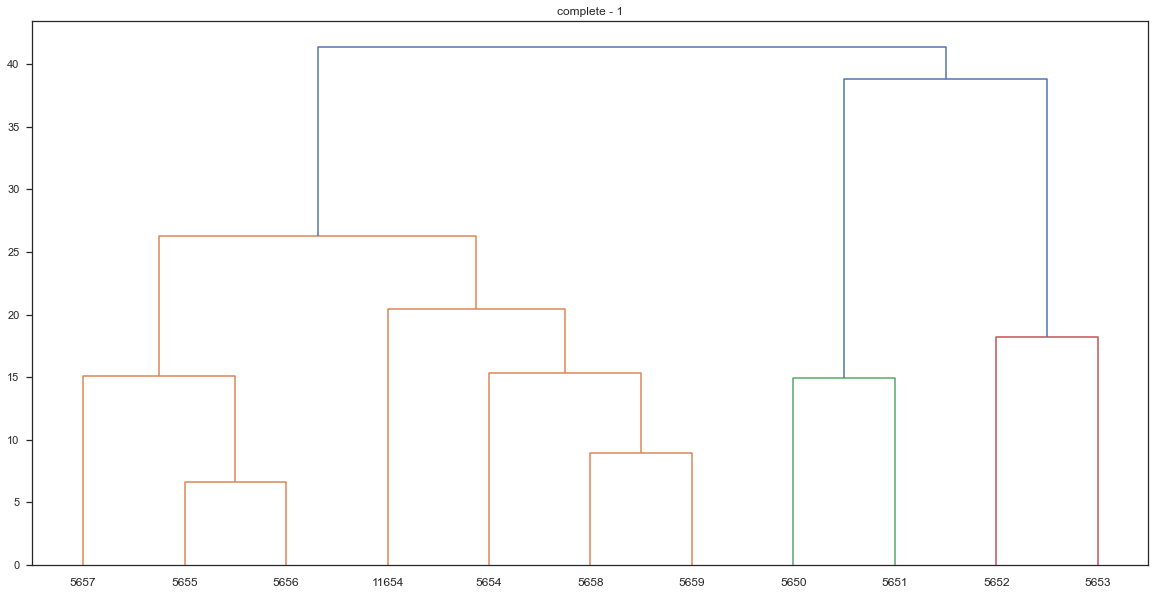

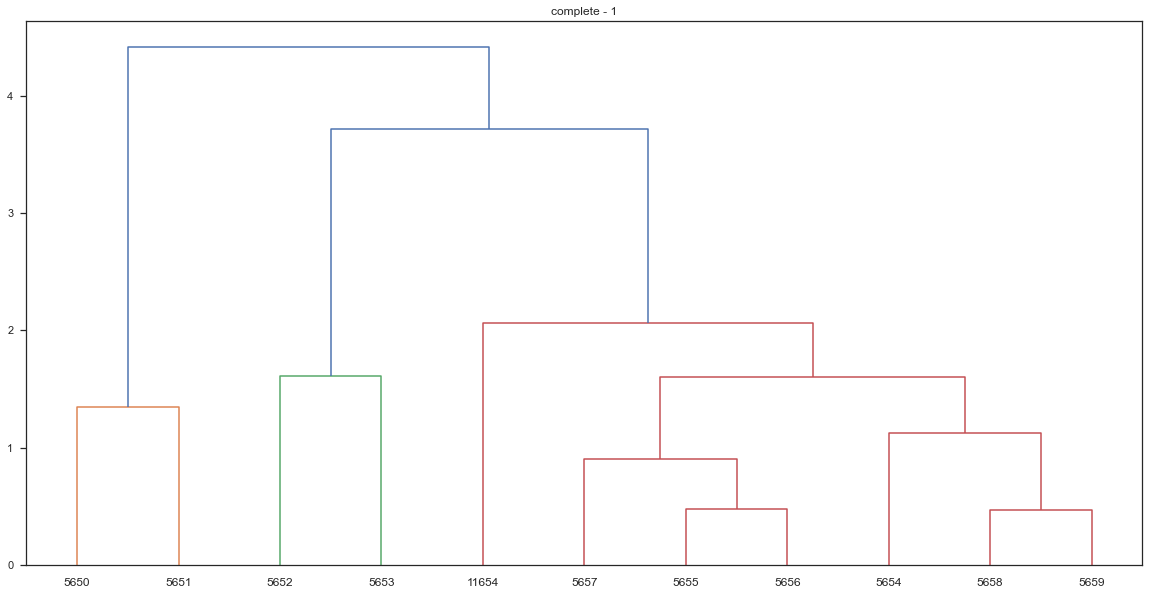

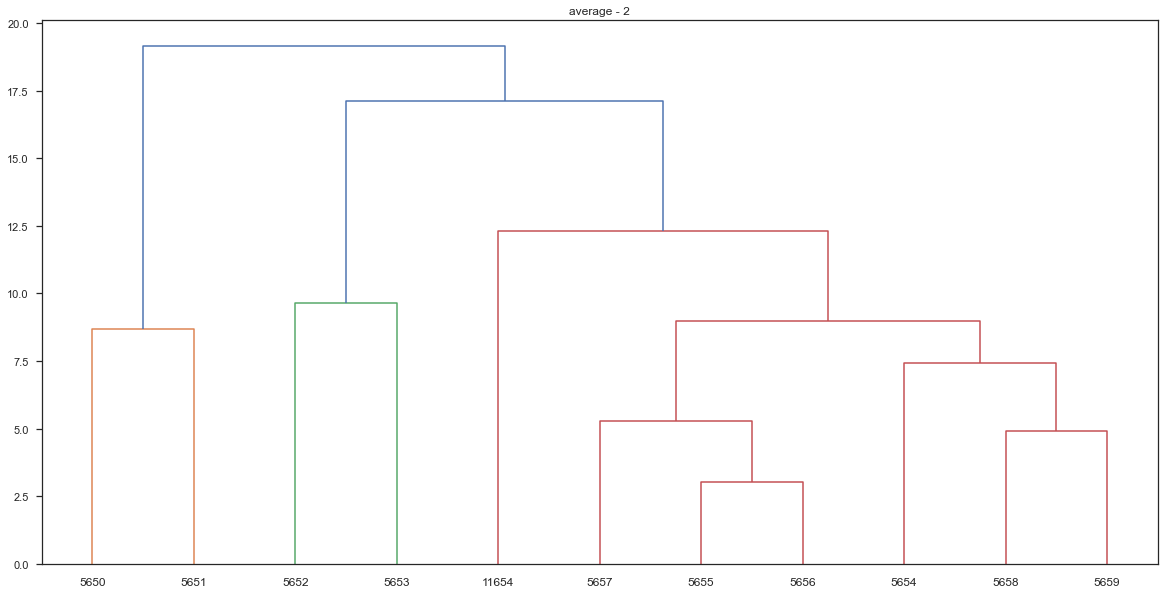

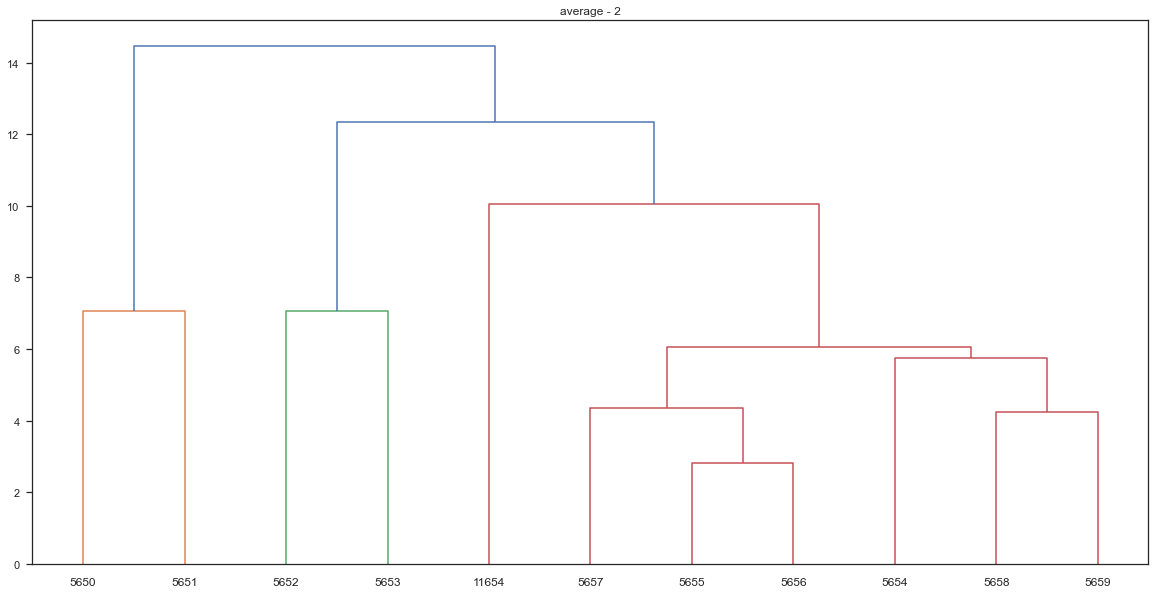

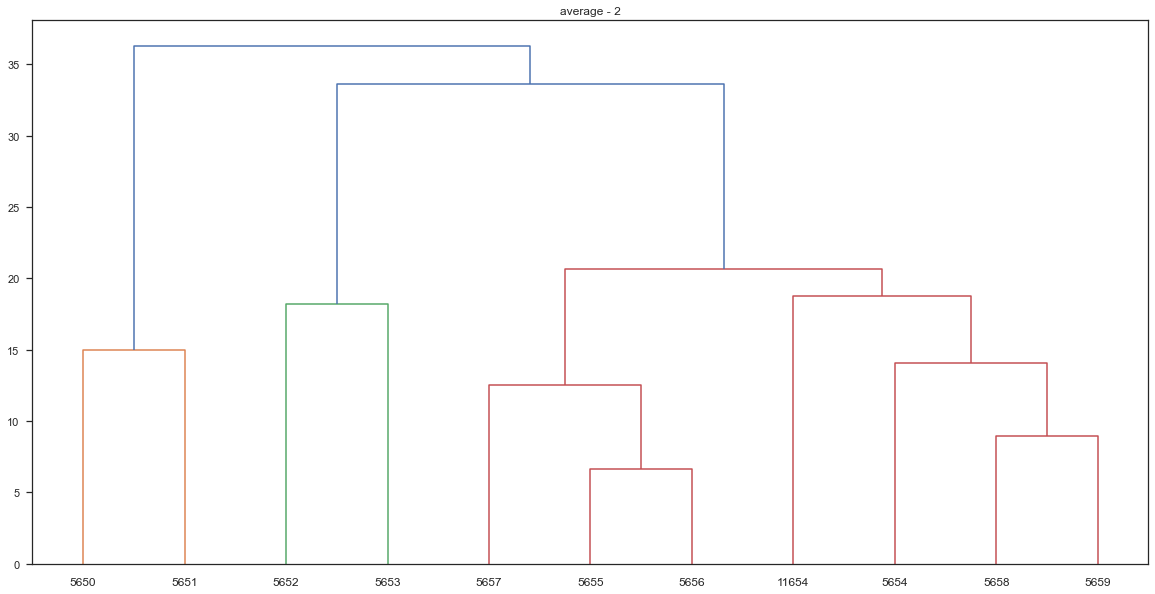

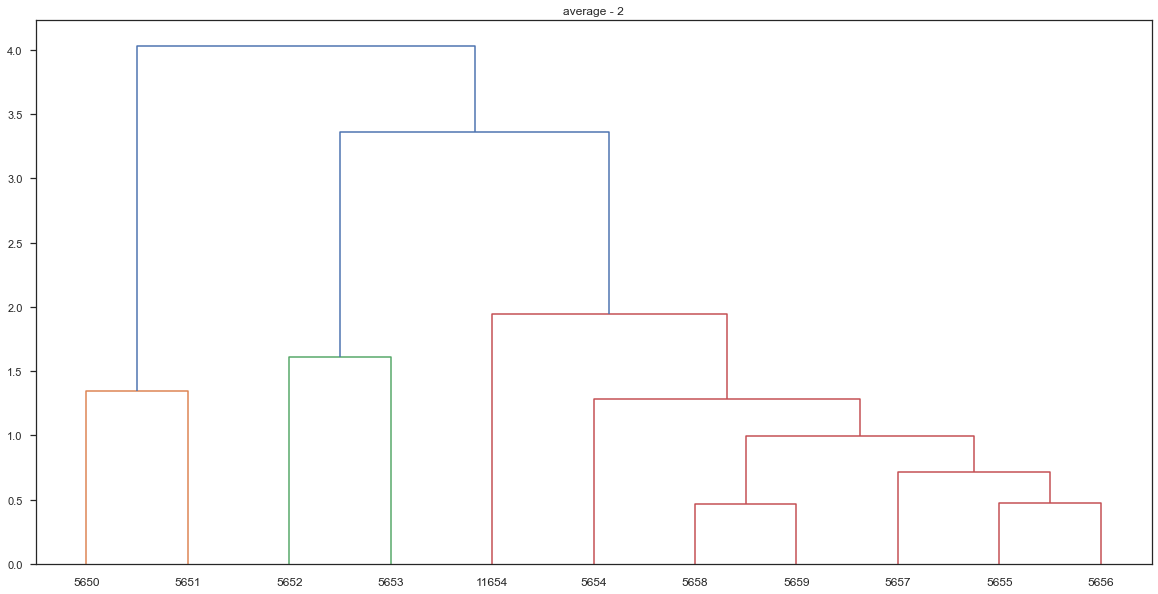

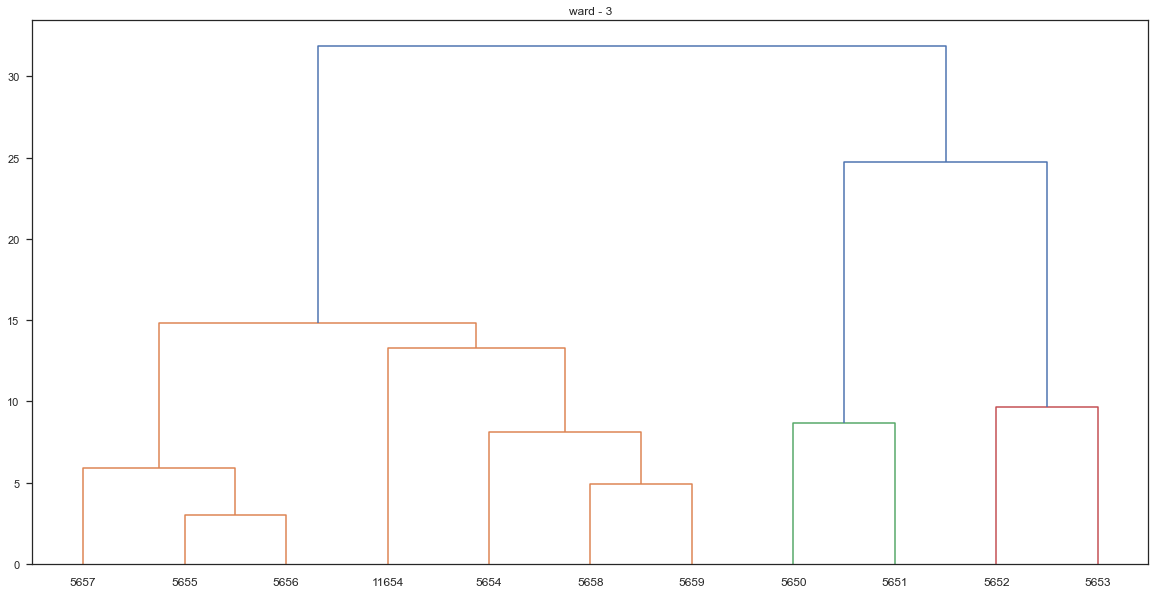

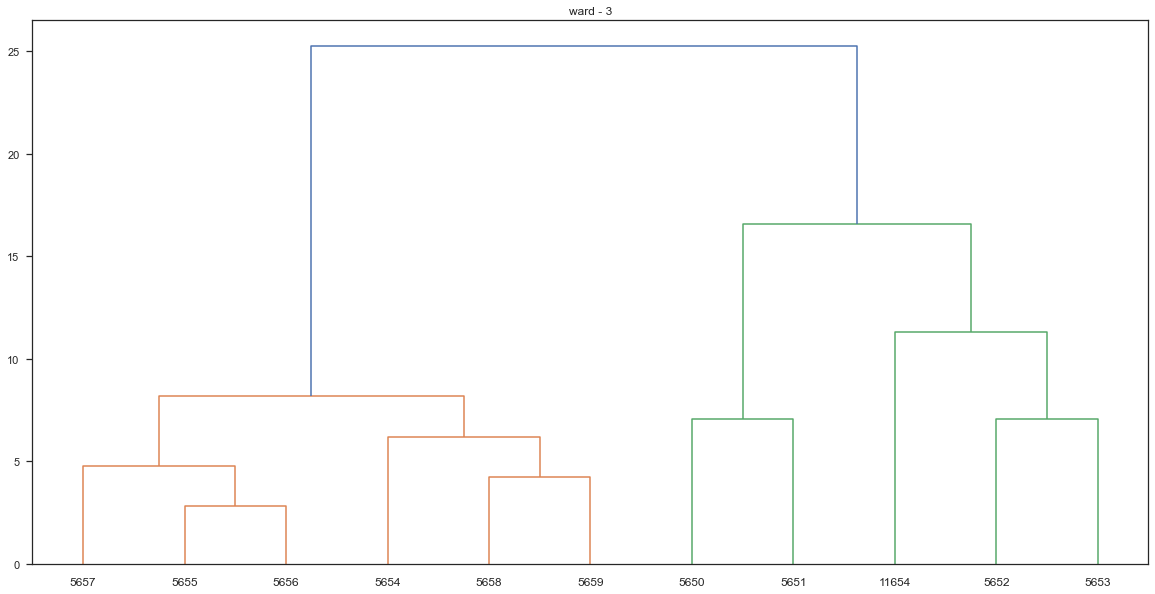

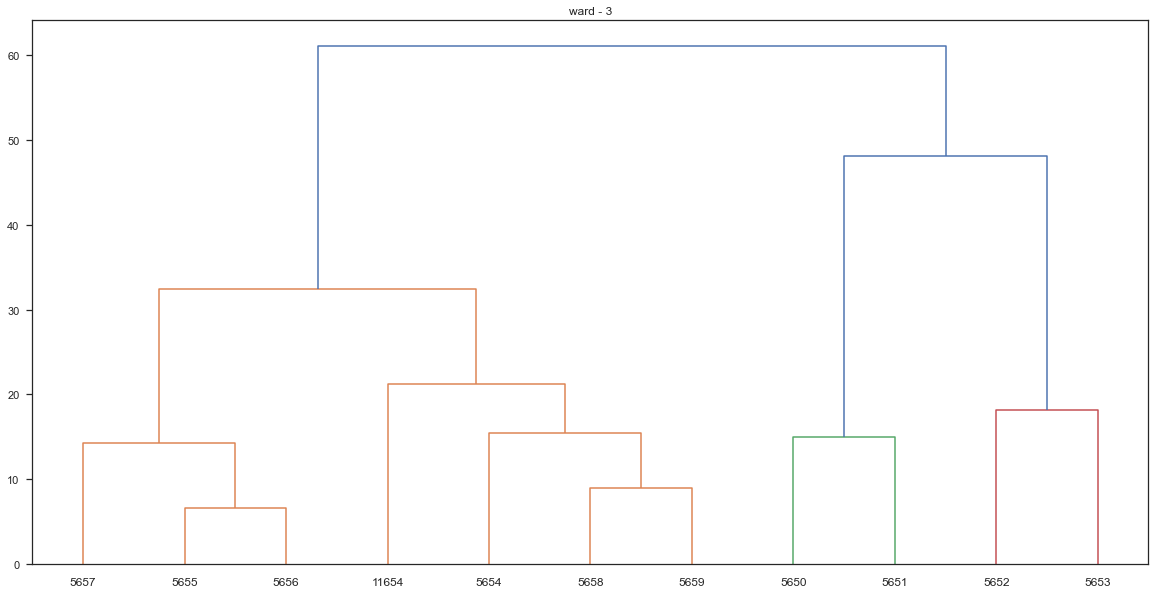

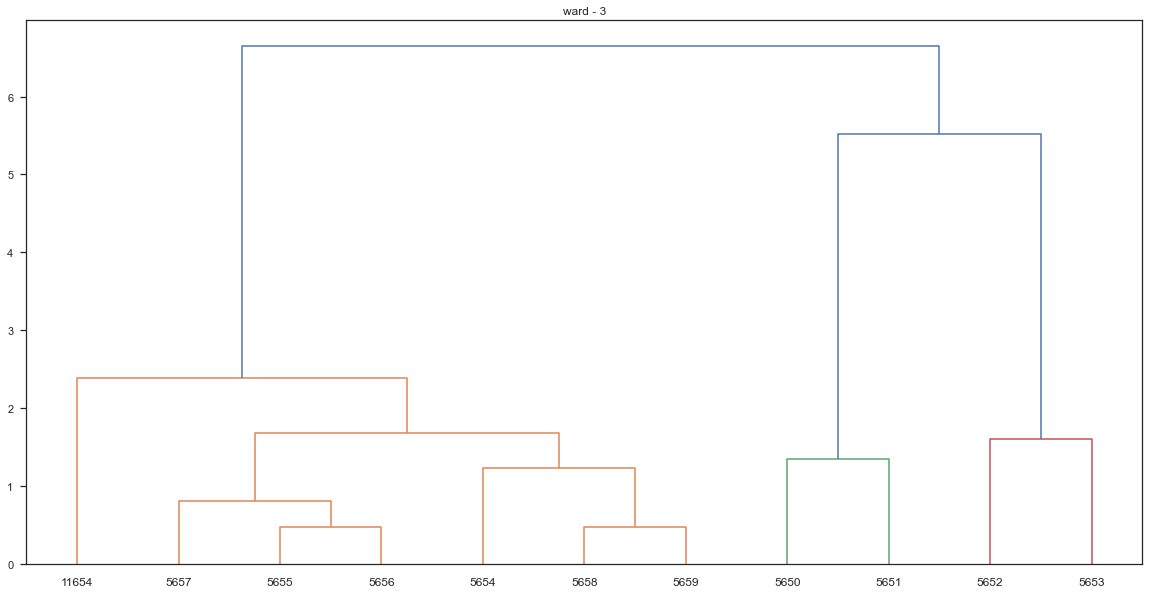

In [104]:
precomputed = [euclidean_dist, chebyshev_dist, mannhattan_dist, canberra_dist]
methods = ['single', 'complete', 'average', 'ward']
for i in range(len(methods)):
    for j in range(4):
        plt.figure(figsize=(20,10)).subplots(1)
        plt.title(f'{methods[i]} - {i}')
        linkage_matx = cluster.hierarchy.linkage(precomputed[j], method=methods[i])
        cluster.hierarchy.dendrogram(linkage_matx, labels=indexed_data.index)